### Importando as dependencias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import statsmodels.api as sm

path = Path('dados')

### Buscando os dados tratados pelo outro arquivo

In [192]:
pnad_completa = pd.read_csv(path/'dados_tratados.csv',index_col='Unnamed: 0')
pnad_completa.head()

,Ano,Trimestre,UF,Capital,RM_RIDE,UPA,Estrato,V1008,V1014,V1016,...,VD4020,VD4023,VD4030,VD4031,VD4032,VD4033,VD4034,VD4035,VD4036,VD4037
0,2019,4,11,11.0,NaN,110000016,1110011,1,7,4,...,2100.0,.,NaN,036,.,.,.,030,2.0,2.0
1,2019,4,11,11.0,NaN,110000016,1110011,1,7,4,...,NaN,.,6.0,.,.,.,.,.,NaN,NaN
2,2019,4,11,11.0,NaN,110000016,1110011,1,7,4,...,NaN,.,6.0,.,.,.,.,.,NaN,NaN
3,2019,4,11,11.0,NaN,110000016,1110011,1,7,4,...,NaN,.,NaN,.,.,.,.,.,NaN,NaN
4,2019,4,11,11.0,NaN,110000016,1110011,3,7,4,...,NaN,.,3.0,.,.,.,.,.,NaN,NaN


### Separando por Norte x Sul
---

In [193]:
# a coluna local representa se o entrevistado mora no sul do pais.
# O valor sera 1 quando a UF se encontrar no sul do pais e 0 se se encontra no norte

UFS_NORTE = [11,12,13,14,15,16,17,21]
UFS_SUL = [41,42,43]

pnad_norte_sul = pnad_completa.loc[(pnad_completa['UF'].isin(UFS_NORTE))|(pnad_completa['UF'].isin(UFS_SUL))]

new_col = list()
for i in pnad_norte_sul['UF']:
    if i in UFS_SUL:
        new_col.append(1)
    else: new_col.append(0)
pnad_norte_sul['local'] = new_col

<ipython-input-193-43219b335967>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pnad_norte_sul['local'] = new_col


### Criando coluna de entrada no ensino superior
---
Criada com base nas colunas V3003A e V3009A

In [194]:
indexes = pnad_norte_sul.loc[(pnad_norte_sul['V3003A'] >= 7)|(pnad_norte_sul['V3009A'] >= 12)].index.values

In [195]:
pnad_norte_sul['ensino_superior']=np.where(pnad_norte_sul.index.isin(indexes),1,0)

<ipython-input-195-ddb8fe22f5f6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pnad_norte_sul['ensino_superior']=np.where(pnad_norte_sul.index.isin(indexes),1,0)


In [196]:
pnad_norte_sul['ensino_superior'].value_counts(normalize=True)

0    0.852045
1    0.147955
Name: ensino_superior, dtype: float64

In [197]:
pnad_norte_sul.loc[pnad_norte_sul['local']==1]['ensino_superior'].value_counts(normalize=True)

0    0.817245
1    0.182755
Name: ensino_superior, dtype: float64

In [198]:
pnad_norte_sul.loc[pnad_norte_sul['local']==0]['ensino_superior'].value_counts(normalize=True)

0    0.880076
1    0.119924
Name: ensino_superior, dtype: float64

### Selecionando as variaveis de analise:


In [216]:
x_cols = ['V2010','V2007','V1022','V1023','local','V3002A']
y_col = 'ensino_superior'
interest_cols = x_cols.copy()
interest_cols.append(y_col)
pnad_trabalho = pnad_norte_sul[interest_cols]

In [217]:
pnad_trabalho.to_csv(path/'pnad_filtrada___.csv')

In [218]:
pnad_trabalho = pd.read_csv(path/'pnad_filtrada___.csv',index_col='Unnamed: 0')
pnad_trabalho.head()


,V2010,V2007,V1022,V1023,local,V3002A,ensino_superior
0,4,2,1,1,0,NaN,0
1,4,2,1,1,0,NaN,0
2,4,2,1,1,0,NaN,0
3,4,1,1,1,0,1.0,0
4,4,1,1,1,0,NaN,0


### Matriz de Correlacao
---

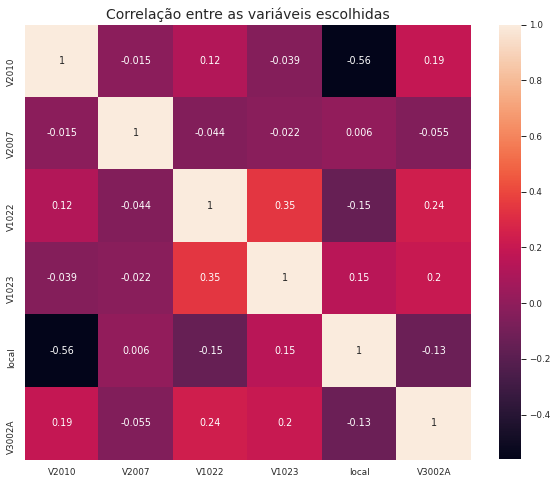

In [219]:
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('paper')
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(pnad_trabalho[x_cols].corr(),annot=True,ax=ax)
ax.set_title('Correlação entre as variáveis escolhidas',size=14);

<ipython-input-220-23bab3c3773e>:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  pnad_trabalho[x_cols].hist(ax=ax);


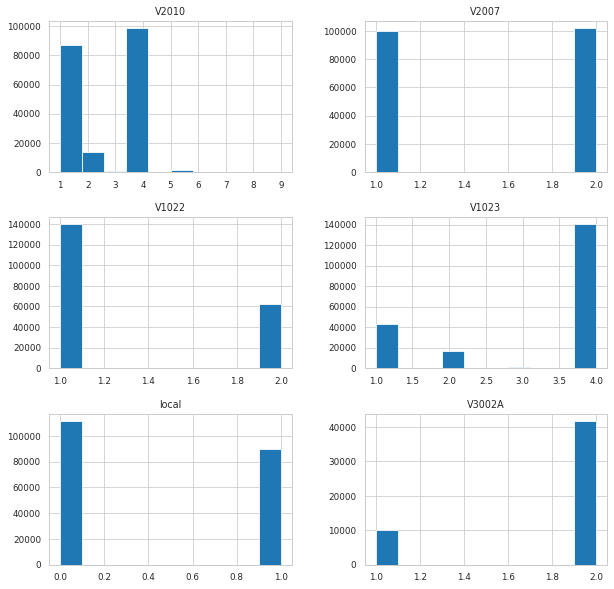

In [220]:
fig,ax=plt.subplots(figsize=(10,10))

pnad_trabalho[x_cols].hist(ax=ax);

### Dividindo os dados de treino e os dados de teste para a regressao
---

In [305]:
pnad_trabalho.loc[pnad_trabalho['V3002A']==2.]['ensino_superior'].sum()

2965

In [304]:
pnad_trabalho.loc[pnad_trabalho['V3002A']==2.].shape

(41848, 17)

In [374]:
x_cols = ['V2010','V2007','V1022','V1023','local','V3002A']
y_col = 'ensino_superior'

dumm_sex = pd.get_dummies(pnad_trabalho['V2007'],prefix='V2007')
pnad_trabalho[dumm_sex.columns] = dumm_sex

dumm_race = pd.get_dummies(pnad_trabalho['V2010'],prefix='V2010')
pnad_trabalho[dumm_race.columns] = dumm_race

dumm_school = pd.get_dummies(pnad_trabalho['V3002A'],prefix='V3002A')
pnad_trabalho[dumm_school.columns] = dumm_school

In [376]:
for i in dumm_sex:
    print(i)

V2007_1
V2007_2


In [377]:
x_cols.remove('V2007')
for sex in dumm_sex.columns:
    x_cols.append(sex)

x_cols.remove('V2010')
for race in dumm_race.columns:
    x_cols.append(race)
    
x_cols.remove('V3002A')
for school in dumm_school.columns:
    x_cols.append(school)

In [378]:
x_cols

['V1022',
 'V1023',
 'local',
 'V2007_1',
 'V2007_2',
 'V2010_1',
 'V2010_2',
 'V2010_3',
 'V2010_4',
 'V2010_5',
 'V2010_9',
 'V3002A_1.0',
 'V3002A_2.0']

In [380]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedShuffleSplit

pnad_trabalho_ = pnad_trabalho.dropna()

X = pnad_trabalho_[x_cols]
y= pnad_trabalho_['ensino_superior']

ssx = StratifiedShuffleSplit(n_splits=1,test_size=0.1)
for train_idx, test_idx in ssx.split(X,y):
    print("TRAIN:", train_idx, "TEST:", test_idx)
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

TRAIN: [35577 44494 45505 ...   146 40575 16050] TEST: [49029 39150  2533 ... 34679 19498 44017]


In [384]:
X_train.join(y_train).to_csv('dados_dummies.csv')

In [382]:
X_train.shape

(46754, 13)

### Probit
---

In [385]:
probit = sm.Probit(y_train,sm.add_constant(X_train))
probit_fit = probit.fit(maxiter=100)
probit_fit.summary()

Optimization terminated successfully.
         Current function value: 0.327413
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Probit Regression Results                           
==============================================================================
Dep. Variable:        ensino_superior   No. Observations:                46754
Model:                         Probit   Df Residuals:                    46743
Method:                           MLE   Df Model:                           10
Date:                Wed, 31 Mar 2021   Pseudo R-squ.:                  0.2950
Time:                        21:06:26   Log-Likelihood:                -15308.
converged:                       True   LL-Null:                       -21714.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0101        nan        nan        nan         nan         nan
V1022         -0.3738      0.023    -16.452      0.000      -0.418      -0.329
V1023         -0.0655      0.006    -10.348      0.000      -0.078      -0.053
local          0.1243      0.020      6.191      0.000       0.085       0.164
V2007_1       -0.0879        nan        nan        nan         nan         nan
V2007_2        0.0980        nan        nan        nan         nan         nan
V2010_1       -0.0372        nan        nan        nan         nan         nan
V2010_2        0.1074        nan        nan        nan         nan         nan
V2010_3        0.1414        nan        nan        nan         nan         nan
V2010_4       -0.0871        nan        nan        nan         nan         nan
V2010_5       -0.0409        nan        nan        nan         nan         nan
V2010_9       -0.0735        nan        nan        nan         nan         nan
V3002A_1.0     0.8107        nan        nan        nan         nan         nan
V3002A_2.0    -0.8005        nan        nan        nan         nan         nan
==============================================================================
"""

In [387]:
preds_probit = probit_fit.predict(sm.add_constant(X_test)).to_frame()
preds_probit['truth'] = y_test
preds_probit['prediction'] = (preds_probit[0]>0.499).astype('int32')
preds_probit.head()

,0,truth,prediction
475660,0.714522,0,1
430226,0.573025,0,1
9685,0.054656,0,0
34741,0.111474,0,0
76381,0.086047,0,0


In [388]:
index_entram = preds_probit.loc[preds_probit['prediction'] == 1].index
index_naoentram = preds_probit.loc[preds_probit['prediction'] == 0].index

#### Analise resultados Probit
---

In [389]:
dummy_cols = ['V2010_1','local','V2010_2','V2010_3','V2010_4','V2010_5','V2010_9','V3002A_1.0','V3002A_2.0']
previsao_entram = X_test.loc[index_entram].join(preds_probit.loc[preds_probit['prediction'] == 1]['prediction'])
previsao_naoentram = X_test.loc[index_naoentram].join(preds_probit.loc[preds_probit['prediction'] == 0]['prediction'])

In [390]:
previsao_entram.sample(10)

,V1022,V1023,local,V2007_1,V2007_2,V2010_1,V2010_2,V2010_3,V2010_4,V2010_5,V2010_9,V3002A_1.0,V3002A_2.0,prediction
434934,1,1,1,0,1,0,0,0,1,0,0,1,0,1
84006,1,4,0,1,0,0,0,0,1,0,0,1,0,1
472613,1,1,1,1,0,1,0,0,0,0,0,1,0,1
44139,1,1,0,0,1,0,0,0,1,0,0,1,0,1
479082,1,1,1,0,1,1,0,0,0,0,0,1,0,1
47332,1,4,0,1,0,0,0,0,1,0,0,1,0,1
443167,1,4,1,0,1,1,0,0,0,0,0,1,0,1
416843,1,4,1,0,1,1,0,0,0,0,0,1,0,1
42437,1,1,0,1,0,0,0,0,1,0,0,1,0,1
421975,1,4,1,0,1,1,0,0,0,0,0,1,0,1


In [391]:
previsao_naoentram.sample(10)

,V1022,V1023,local,V2007_1,V2007_2,V2010_1,V2010_2,V2010_3,V2010_4,V2010_5,V2010_9,V3002A_1.0,V3002A_2.0,prediction
96960,1,4,0,1,0,0,0,0,1,0,0,0,1,0
40164,1,1,0,0,1,0,0,0,1,0,0,0,1,0
70093,1,4,0,0,1,0,0,0,1,0,0,0,1,0
90314,1,1,0,0,1,0,0,0,1,0,0,0,1,0
32457,2,4,0,0,1,0,0,0,1,0,0,0,1,0
80460,2,4,0,1,0,1,0,0,0,0,0,0,1,0
33327,1,4,0,1,0,0,0,0,1,0,0,0,1,0
21834,2,4,0,1,0,1,0,0,0,0,0,0,1,0
44804,1,4,0,1,0,0,0,0,1,0,0,0,1,0
98060,2,4,0,1,0,0,0,1,0,0,0,0,1,0


In [392]:
gt_df = X_train.join(y_train)
entram_gt = gt_df.loc[gt_df['ensino_superior'] == 1]
nao_entram_gt = gt_df.loc[gt_df['ensino_superior'] == 1].dropna()

entra_truth = (entram_gt[dummy_cols]
                 .sum()
                 .to_frame()
                 .rename(columns={0:'entram'}))

entra_frame = (previsao_entram[dummy_cols]
                 .sum()
                 .to_frame()
                 .rename(columns={0:'entram'}))

naoentra_truth = (nao_entram_gt[dummy_cols]
                 .sum()
                 .to_frame()
                 .rename(columns={0:'nao_entram'}))

naoentra_frame = (previsao_naoentram[dummy_cols]
                 .sum()
                 .to_frame()
                 .rename(columns={0:'nao_entram'}))

full_reg_truth = entra_truth.join(naoentra_truth)
full_reg_truth['total'] = full_reg_truth['entram'] + full_reg_truth['nao_entram']
full_reg_truth['pct_entram'] = np.round(((full_reg_truth['entram']/full_reg_truth['total'])*100),2)
full_reg_truth['pct_naoentram'] = np.round(((full_reg_truth['nao_entram']/full_reg_truth['total'])*100),2)

full_reg = entra_frame.join(naoentra_frame)
full_reg['total'] = full_reg['entram'] + full_reg['nao_entram']
full_reg['pct_entram'] = np.round(((full_reg['entram']/full_reg['total'])*100),2)
full_reg['pct_naoentram'] = np.round(((full_reg['nao_entram']/full_reg['total'])*100),2)

In [393]:
full_reg['pct_entram']

V2010_1       26.68
local         24.79
V2010_2       16.67
V2010_3       32.00
V2010_4       11.92
V2010_5       11.63
V2010_9         NaN
V3002A_1.0    92.63
V3002A_2.0     0.00
Name: pct_entram, dtype: float64

In [394]:
full_reg['pct_naoentram']

V2010_1        73.32
local          75.21
V2010_2        83.33
V2010_3        68.00
V2010_4        88.08
V2010_5        88.37
V2010_9          NaN
V3002A_1.0      7.37
V3002A_2.0    100.00
Name: pct_naoentram, dtype: float64

In [395]:
diff_entrou_pr = (previsao_entram.describe() - previsao_naoentram.describe()).T
diff_entrou_pr['positive'] = diff_entrou_pr['mean'] > 0

In [396]:
diff_entrou_pr

,count,mean,std,min,25%,50%,75%,max,positive
V1022,-3311.0,-0.371482,-0.405311,0.0,0.0,0.0,-1.0,0.0,False
V1023,-3311.0,-0.736492,0.210379,0.0,-1.0,-2.0,0.0,0.0,False
local,-3311.0,0.172315,0.021607,0.0,0.0,1.0,0.0,0.0,True
V2007_1,-3311.0,-0.059780,-0.002575,0.0,0.0,-1.0,0.0,0.0,False
V2007_2,-3311.0,0.059780,-0.002575,0.0,0.0,1.0,0.0,0.0,True
V2010_1,-3311.0,0.227994,0.014847,0.0,0.0,1.0,0.0,0.0,True
V2010_2,-3311.0,-0.005703,-0.010935,0.0,0.0,0.0,0.0,0.0,False
V2010_3,-3311.0,0.004495,0.028708,0.0,0.0,0.0,0.0,0.0,True
V2010_4,-3311.0,-0.223159,-0.017307,0.0,0.0,-1.0,0.0,0.0,False
V2010_5,-3311.0,-0.003627,-0.021412,0.0,0.0,0.0,0.0,0.0,False


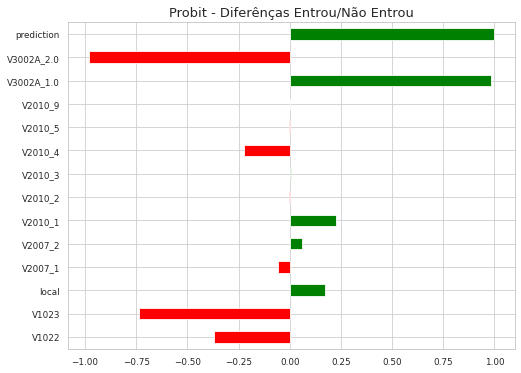

In [397]:
fig,ax= plt.subplots(figsize=(8,6))
diff_entrou_pr['mean'].plot(kind='barh',
                        color=diff_entrou_pr.positive.map({True: 'g', False: 'r'}),
                        ax=ax)

ax.set_title('Probit - Diferênças Entrou/Não Entrou',size=13);

In [398]:
pnad_trabalho['V2010'].value_counts(normalize=True).sort_values(ascending=False)

4    0.489634
1    0.431580
2    0.066284
5    0.007699
3    0.004685
9    0.000119
Name: V2010, dtype: float64

#### Analise dos que nao entram

In [402]:
previsao_naoentram = X_test.loc[index_naoentram]

In [403]:
previsao_naoentram.describe()

,V1022,V1023,local,V2007_1,V2007_2,V2010_1,V2010_2,V2010_3,V2010_4,V2010_5,V2010_9,V3002A_1.0,V3002A_2.0
count,4253.000000,4253.000000,4253.000000,4253.000000,4253.000000,4253.000000,4253.000000,4253.000000,4253.000000,4253.000000,4253.0,4253.000000,4253.000000
mean,1.377851,3.286386,0.353162,0.506701,0.493299,0.354808,0.058782,0.003997,0.573478,0.008935,0.0,0.017635,0.982365
std,0.484907,1.212508,0.478009,0.500014,0.500014,0.478511,0.235244,0.063104,0.494630,0.094112,0.0,0.131635,0.131635
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
25%,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.000000
50%,1.000000,4.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.000000,1.000000
75%,2.000000,4.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.000000,1.000000
max,2.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000


f1_probit -> 0.6019417475728155
acc_probit -> 0.8579403272377286
recall_probit -> 0.6118421052631579
precision_probit -> 0.5923566878980892


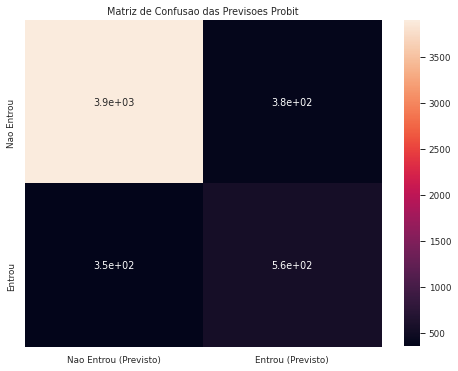

In [404]:
from sklearn.metrics import confusion_matrix,f1_score,accuracy_score,recall_score,precision_score

cm = confusion_matrix(preds_probit['truth'],preds_probit['prediction'])

metrics = {'f1_probit':f1_score(preds_probit['truth'],preds_probit['prediction']),
           'acc_probit':accuracy_score(preds_probit['truth'],preds_probit['prediction']),
           'recall_probit':recall_score(preds_probit['truth'],preds_probit['prediction']),
           'precision_probit':precision_score(preds_probit['truth'],preds_probit['prediction'])}

for k,v in metrics.items():
    print(f'{k} -> {v}')

_,ax=plt.subplots(figsize=(8,6))

sns.heatmap(cm,annot=True,xticklabels=['Nao Entrou (Previsto)','Entrou (Previsto)'],
            yticklabels=['Nao Entrou','Entrou'],ax=ax)
ax.set_title('Matriz de Confusao das Previsoes Probit');

In [405]:
cm

array([[3899,  384],
       [ 354,  558]])

### Logit
---

In [406]:
logit = sm.Logit(y_train,sm.add_constant(X_train))
logit_fit = logit.fit(maxiter=100)
logit_fit.summary()

         Current function value: 0.328795
         Iterations: 100


/home/davi_lirio/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:        ensino_superior   No. Observations:                46754
Model:                          Logit   Df Residuals:                    46743
Method:                           MLE   Df Model:                           10
Date:                Wed, 31 Mar 2021   Pseudo R-squ.:                  0.2920
Time:                        21:07:01   Log-Likelihood:                -15372.
converged:                      False   LL-Null:                       -21714.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0210        nan        nan        nan         nan         nan
V1022         -0.6493      0.044    -14.850      0.000      -0.735      -0.564
V1023         -0.1017      0.012     -8.708      0.000      -0.125      -0.079
local          0.2424      0.037      6.555      0.000       0.170       0.315
V2007_1       -0.1918        nan        nan        nan         nan         nan
V2007_2        0.1707        nan        nan        nan         nan         nan
V2010_1       -0.0729        nan        nan        nan         nan         nan
V2010_2        0.2360        nan        nan        nan         nan         nan
V2010_3        0.2316        nan        nan        nan         nan         nan
V2010_4       -0.1313        nan        nan        nan         nan         nan
V2010_5       -0.0654        nan        nan        nan         nan         nan
V2010_9       -0.2190        nan        nan        nan         nan         nan
V3002A_1.0     1.3818        nan        nan        nan         nan         nan
V3002A_2.0    -1.4028        nan        nan        nan         nan         nan
==============================================================================
"""

In [407]:
preds_logit = logit_fit.predict(sm.add_constant(X_test)).to_frame()
preds_logit['truth'] = y_test
preds_logit['prediction'] = (preds_logit[0]>0.499).astype('int32')
preds_logit.head()

,0,truth,prediction
475660,0.721105,0,1
430226,0.570087,0,1
9685,0.057150,0,0
34741,0.105696,0,0
76381,0.084532,0,0


#### Analise resultados Logit
---

f1_logit -> 0.5890788747931605
acc_logit -> 0.8565928777670837
recall_logit -> 0.5855263157894737
precision_logit -> 0.5926748057713651


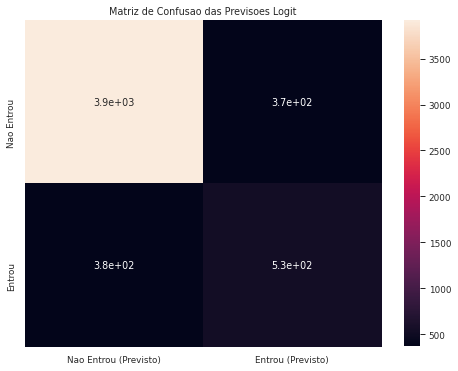

In [416]:
from sklearn.metrics import confusion_matrix,f1_score,accuracy_score,recall_score,precision_score

cm = confusion_matrix(preds_logit['truth'],preds_logit['prediction'])

metrics = {'f1_logit':f1_score(preds_logit['truth'],preds_logit['prediction']),
           'acc_logit':accuracy_score(preds_logit['truth'],preds_logit['prediction']),
           'recall_logit':recall_score(preds_logit['truth'],preds_logit['prediction']),
           'precision_logit':precision_score(preds_logit['truth'],preds_logit['prediction'])}

for k,v in metrics.items():
    print(f'{k} -> {v}')

_,ax=plt.subplots(figsize=(8,6))

sns.heatmap(cm,annot=True,xticklabels=['Nao Entrou (Previsto)','Entrou (Previsto)'],
            yticklabels=['Nao Entrou','Entrou'],ax=ax)
ax.set_title('Matriz de Confusao das Previsoes Logit');

In [417]:
cm

array([[3916,  367],
       [ 378,  534]])

In [409]:
index_entram_l = preds_logit.loc[preds_logit['prediction'] == 1].index
index_naoentram_l = preds_logit.loc[preds_logit['prediction'] == 0].index

In [418]:
entram_l = X_test.loc[index_entram_l]
naoentram_l = X_test.loc[index_naoentram_l]

dummy_cols = ['V2010_1','local','V2010_2','V2010_3','V2010_4','V2010_5','V2010_9','V3002A_1.0','V3002A_2.0']
previsao_entram = X_test.loc[index_entram_l].join(preds_logit.loc[preds_logit['prediction'] == 1]['prediction'])
previsao_naoentram = X_test.loc[index_naoentram_l].join(preds_logit.loc[preds_logit['prediction'] == 0]['prediction'])

In [427]:
sample_e = previsao_entram.sample(10)
for col in sample_e.columns:
    print(sample_e[col].value_counts(normalize = True))
    print('\n')

1    1.0
Name: V1022, dtype: float64


1    0.5
4    0.4
2    0.1
Name: V1023, dtype: float64


0    0.6
1    0.4
Name: local, dtype: float64


0    0.8
1    0.2
Name: V2007_1, dtype: float64


1    0.8
0    0.2
Name: V2007_2, dtype: float64


0    0.5
1    0.5
Name: V2010_1, dtype: float64


0    0.9
1    0.1
Name: V2010_2, dtype: float64


0    1.0
Name: V2010_3, dtype: float64


0    0.7
1    0.3
Name: V2010_4, dtype: float64


0    0.9
1    0.1
Name: V2010_5, dtype: float64


0    1.0
Name: V2010_9, dtype: float64


1    1.0
Name: V3002A_1.0, dtype: float64


0    1.0
Name: V3002A_2.0, dtype: float64


1    1.0
Name: prediction, dtype: float64




In [433]:
sample_n

,V1022,V1023,local,V2007_1,V2007_2,V2010_1,V2010_2,V2010_3,V2010_4,V2010_5,V2010_9,V3002A_1.0,V3002A_2.0,prediction
4409,1,1,0,0,1,1,0,0,0,0,0,0,1,0
107373,1,4,0,1,0,0,0,0,1,0,0,0,1,0
106593,2,1,0,1,0,0,0,0,1,0,0,0,1,0
72457,1,1,0,1,0,0,0,0,1,0,0,0,1,0
9604,2,4,0,1,0,1,0,0,0,0,0,1,0,0
6246,1,1,0,0,1,0,0,0,1,0,0,0,1,0
56873,1,2,0,0,1,0,0,0,1,0,0,0,1,0
111209,2,4,0,1,0,0,0,0,1,0,0,0,1,0
28618,1,4,0,0,1,0,0,1,0,0,0,0,1,0
14408,1,4,0,1,0,0,0,0,1,0,0,0,1,0


In [434]:
sample_n  = previsao_naoentram.sample(10)
for col in sample_n.columns:
    print(sample_n[col].value_counts(normalize = True))
    print('\n')

1    0.6
2    0.4
Name: V1022, dtype: float64


4    0.9
1    0.1
Name: V1023, dtype: float64


0    0.5
1    0.5
Name: local, dtype: float64


0    0.5
1    0.5
Name: V2007_1, dtype: float64


0    0.5
1    0.5
Name: V2007_2, dtype: float64


1    0.6
0    0.4
Name: V2010_1, dtype: float64


0    1.0
Name: V2010_2, dtype: float64


0    1.0
Name: V2010_3, dtype: float64


0    0.6
1    0.4
Name: V2010_4, dtype: float64


0    1.0
Name: V2010_5, dtype: float64


0    1.0
Name: V2010_9, dtype: float64


0    1.0
Name: V3002A_1.0, dtype: float64


1    1.0
Name: V3002A_2.0, dtype: float64


0    1.0
Name: prediction, dtype: float64




In [436]:
sample_n.sum()

V1022         14
V1023         37
local          5
V2007_1        5
V2007_2        5
V2010_1        6
V2010_2        0
V2010_3        0
V2010_4        4
V2010_5        0
V2010_9        0
V3002A_1.0     0
V3002A_2.0    10
prediction     0
dtype: int64

In [411]:
diff_entrar = (entram_l.describe() - naoentram_l.describe()).T
diff_entrar['positive'] = diff_entrar['mean'] > 0

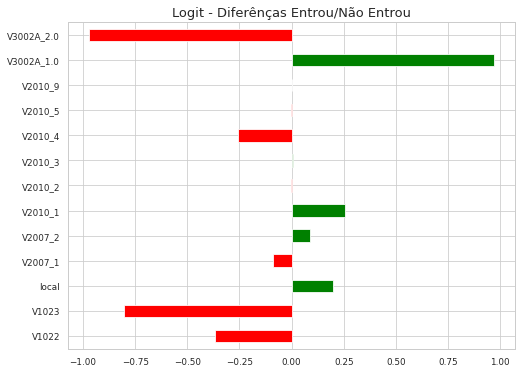

In [412]:
fig,ax= plt.subplots(figsize=(8,6))
diff_entrar['mean'].plot(kind='barh',
                        color=diff_entrar.positive.map({True: 'g', False: 'r'}),
                        ax=ax)

ax.set_title('Logit - Diferênças Entrou/Não Entrou',size=13);

In [415]:
!jupyter nbconvert --to html reg_analise.ipynb  

[NbConvertApp] Converting notebook reg_analise.ipynb to html
[NbConvertApp] Writing 547842 bytes to reg_analise.html
